<a href="https://colab.research.google.com/github/yogeetha136/Liver-Cirrhosis-Survival-Prediction/blob/main/Cirrhuss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np

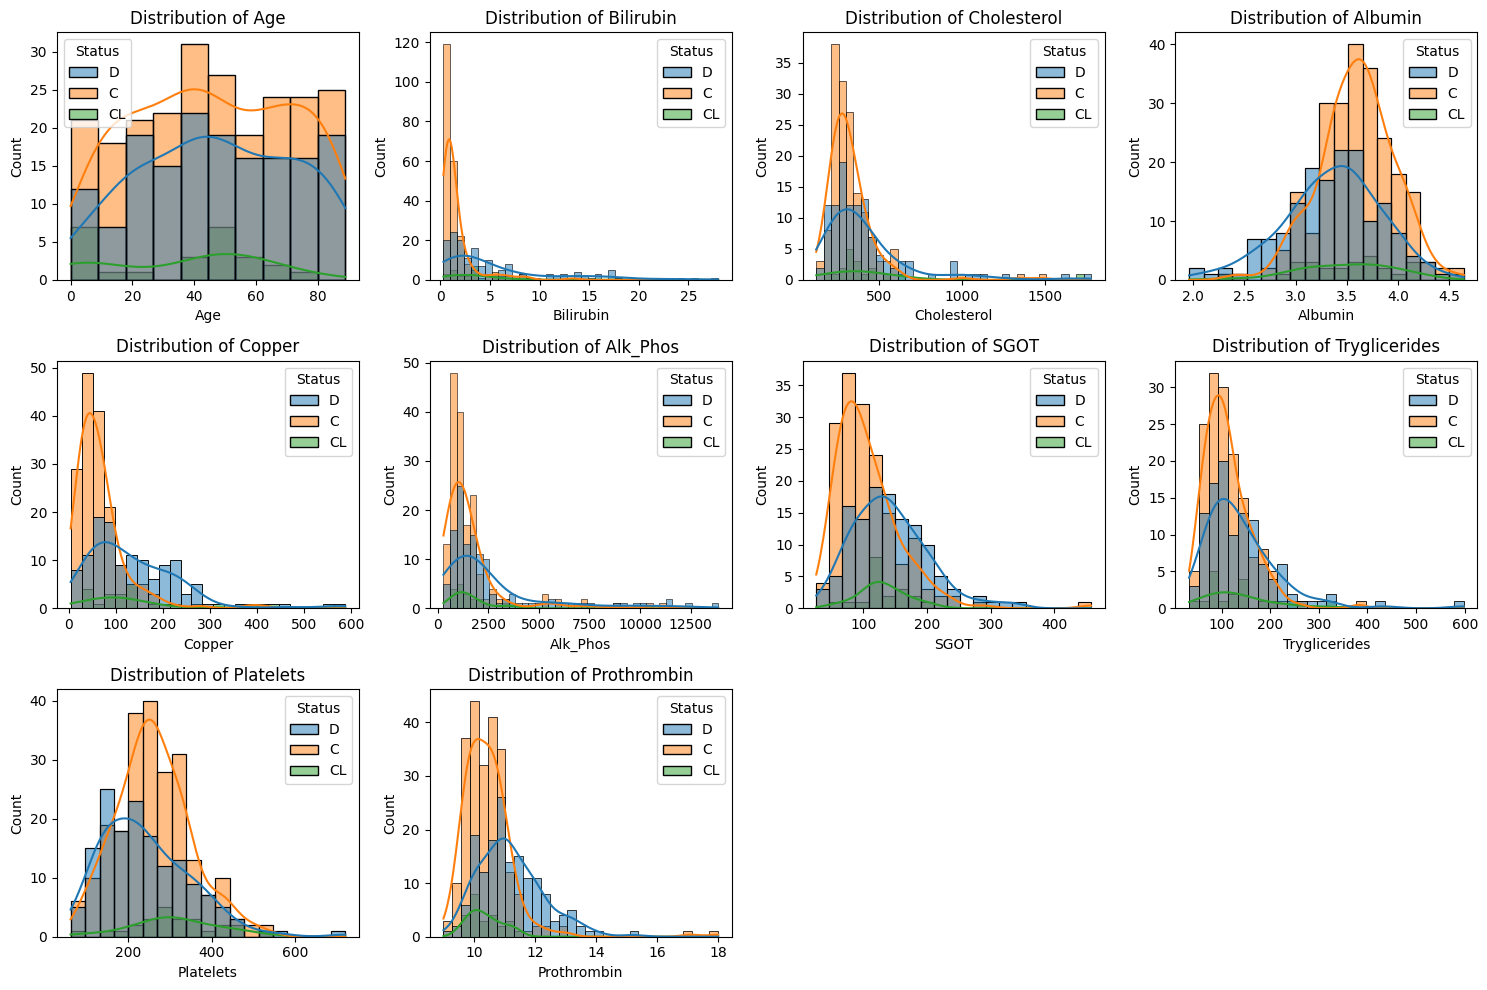

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot distribution of numerical features with hue for the entire dataset
numerical_features = ['Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 4, i)
    sns.histplot(data, x=feature, hue='Status', kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()


In [ ]:
from google.colab import files
# Upload file
uploaded = files.upload()

Saving cirrhosis.csv to cirrhosis.csv


In [ ]:
# Load the uploaded file into a DataFrame
for filename in uploaded.keys():
    data = pd.read_csv(filename)
    print(f"Loaded {filename} with shape: {data.shape}")

Loaded cirrhosis.csv with shape: (418, 20)


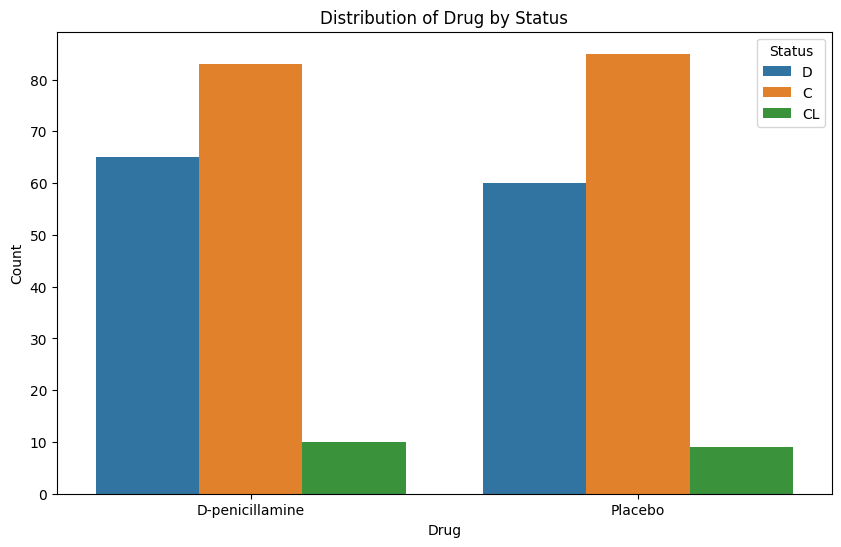

In [ ]:
# Example for categorical feature 'Drug'
plt.figure(figsize=(10, 6))
sns.countplot(x='Drug', hue='Status', data=data)
plt.title('Distribution of Drug by Status')
plt.xlabel('Drug')
plt.ylabel('Count')
plt.legend(title='Status')
plt.show()



In [ ]:
# Preprocessing function
def preprocess_data(data):
    # Drop rows with missing Drug values
    data = data.dropna(subset=['Drug'])

    # Fill missing values for other columns
    data.fillna(data.mean(numeric_only=True), inplace=True)

    # Separate features and target variable
    X = data.drop('Status', axis=1)  # Use 'Status' as the target variable
    y = data['Status']  # Use 'Status' as the target variable

    # Identify categorical features
    categorical_features = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']

    # Preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(), categorical_features)
        ],
        remainder='passthrough'
    )

    # Apply preprocessing
    X_preprocessed = preprocessor.fit_transform(X)

    return X_preprocessed, y

# Preprocess the data
X_preprocessed, y = preprocess_data(data)

<ipython-input-4-32a691a76bf9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.fillna(data.mean(numeric_only=True), inplace=True)


In [ ]:
# Encode the target variable if it's categorical
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_encoded, test_size=0.2, random_state=42)


In [ ]:
# Address class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
# Dimensionality Reduction using LDA
lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(X_train_resampled, y_train_resampled)
X_test_lda = lda.transform(X_test)

In [ ]:
# Hyperparameter tuning for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced', None]
}
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5)
rf_grid_search.fit(X_train_lda, y_train_resampled)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]})

In [ ]:

# Best RandomForest model
best_rf_model = rf_grid_search.best_estimator_

In [ ]:
# Classification with RandomForest
rf_y_pred = best_rf_model.predict(X_test_lda)
print("Random Forest Classifier:")
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, rf_y_pred)
print(conf_matrix)


Random Forest Classifier:
Confusion Matrix:
[[26  0  3]
 [ 5  3  0]
 [ 1  2 23]]


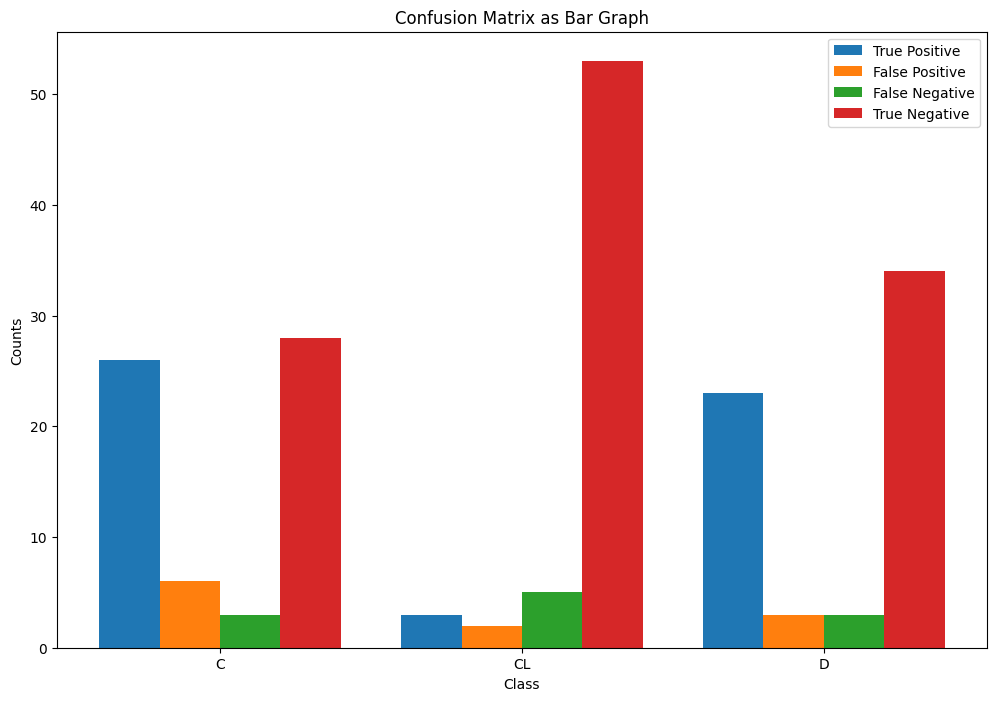

In [ ]:
# Plotting the confusion matrix as a bar graph
classes = le.classes_
n_classes = len(classes)

fig, ax = plt.subplots(figsize=(12, 8))

# Plot true positives, false positives, false negatives, and true negatives
bar_width = 0.2
index = np.arange(n_classes)
bar_width = 0.2

bar1 = ax.bar(index - 1.5 * bar_width, conf_matrix.diagonal(), bar_width, label='True Positive')
bar2 = ax.bar(index - 0.5 * bar_width, conf_matrix.sum(axis=0) - conf_matrix.diagonal(), bar_width, label='False Positive')
bar3 = ax.bar(index + 0.5 * bar_width, conf_matrix.sum(axis=1) - conf_matrix.diagonal(), bar_width, label='False Negative')
bar4 = ax.bar(index + 1.5 * bar_width, conf_matrix.sum() - conf_matrix.sum(axis=0) - conf_matrix.sum(axis=1) + conf_matrix.diagonal(), bar_width, label='True Negative')

ax.set_xlabel('Class')
ax.set_ylabel('Counts')
ax.set_title('Confusion Matrix as Bar Graph')
ax.set_xticks(index)
ax.set_xticklabels(classes)
ax.legend()

plt.show()


In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, rf_y_pred))
print(f"Accuracy: {accuracy_score(y_test, rf_y_pred):.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85        29
           1       0.60      0.38      0.46         8
           2       0.88      0.88      0.88        26

    accuracy                           0.83        63
   macro avg       0.77      0.72      0.73        63
weighted avg       0.82      0.83      0.82        63

Accuracy: 0.8254
